<a href="https://colab.research.google.com/github/AliAkbarBadri/topics-for-types/blob/main/types.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
! pip -q install laserembeddings
! python -m laserembeddings download-models
! pip -q install transformers
! pip -q install parsivar

     |████████████████████████████████| 860kB 6.7MB/s 
     |████████████████████████████████| 51kB 8.8MB/s 

✅   Downloaded https://dl.fbaipublicfiles.com/laser/models/93langs.fcodes    
✅   Downloaded https://dl.fbaipublicfiles.com/laser/models/93langs.fvocab    
✅   Downloaded https://dl.fbaipublicfiles.com/laser/models/bilstm.93langs.2018-12-26.pt    

✨ You're all set!
     |████████████████████████████████| 1.3MB 8.7MB/s 
     |████████████████████████████████| 1.1MB 49.9MB/s 
     |████████████████████████████████| 2.9MB 52.5MB/s 
     |████████████████████████████████| 36.2MB 70kB/s 
     |████████████████████████████████| 1.5MB 43.1MB/s 


In [2]:
import pandas as pd
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import torch
from sklearn.model_selection import train_test_split
from transformers import AutoConfig, AutoTokenizer, AutoModel
from laserembeddings import Laser
from parsivar import *
from __future__ import unicode_literals

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# LASER

In [ ]:
laser = Laser()

In [ ]:
df_types_laser = pd.read_csv("/content/drive/My Drive/topics-for-types/df_types.csv")
df_types_laser.head()

,sentence,انتخاب,بله/خیر,ترجمه,تعامل,تعریف,توضیح,دلیل,ریاضی,لیست,نظر,واقعیت,پیشنهاد
0,تفاوت ترمز عقب دیسکی و کاسه ای چیست؟,0,0,0,0,1,1,0,0,0,1,0,0
1,آیا ترمز ضدقفل ABS در همه چرخ ها عمل می کند؟,0,1,0,0,0,1,0,0,0,1,0,0
2,چرا باوجود نصب بودن ترمز ABS بر روی خودرو، ترم...,0,0,0,0,0,1,1,0,0,1,0,0
3,چرا با وجود نصب بودن Airbag بر روی خودرو، در ه...,0,0,0,0,0,1,1,0,0,1,0,0
4,کلاس های مختلف خودرو چگونه شناسایی می شوند؟,0,0,0,0,1,0,0,0,1,1,0,0


In [ ]:
n_class = len(df_types_laser.columns.values)-1
n_class

12

In [ ]:
df_types_laser['sentence'] = df_types_laser['sentence'].apply(lambda sent: laser.embed_sentences(sent, lang='fa')[0])
df_types_laser.head()

,sentence,انتخاب,بله/خیر,ترجمه,تعامل,تعریف,توضیح,دلیل,ریاضی,لیست,نظر,واقعیت,پیشنهاد
0,"[0.020942228, -8.114154e-05, -0.0009854127, 0....",0,0,0,0,1,1,0,0,0,1,0,0
1,"[0.008679963, 0.0027223488, -0.000162347, 0.01...",0,1,0,0,0,1,0,0,0,1,0,0
2,"[0.011158587, 0.01838572, -8.3516294e-05, 0.01...",0,0,0,0,0,1,1,0,0,1,0,0
3,"[0.00957515, 0.013646437, 7.700363e-05, 0.0117...",0,0,0,0,0,1,1,0,0,1,0,0
4,"[0.027029112, 0.0024084542, 0.0004833732, 0.00...",0,0,0,0,1,0,0,0,1,1,0,0


In [ ]:
X = np.array(df_types_laser[df_types_laser.columns[0]])
X = np.vstack(X)

Y = df_types_laser[df_types_laser.columns[1:]].values

X.shape, Y.shape

((2424, 1024), (2424, 12))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.10)

In [ ]:
len(X_train),len(X_test),len(y_train),len(y_test)

(2181, 243, 2181, 243)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=X[0].shape, name='input_layer'),
    tf.keras.layers.Dense(100, activation='relu', name='Dense_Layer'),
    tf.keras.layers.Dense(100, activation='relu', name='Dense_Layer2'),
    tf.keras.layers.Dense(n_class, activation='sigmoid', name='Output'),
  ], name='LASER_Model')

model.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics=['acc',
                       tfa.metrics.f_scores.F1Score(n_class,'weighted', threshold=0.5, name='f1'),
                       tfa.metrics.f_scores.F1Score(n_class,'macro',threshold=0.5, name='macro'),
                       tfa.metrics.f_scores.F1Score(n_class,'micro',threshold=0.5, name='micro'),
                       tfa.metrics.HammingLoss(mode='multilabel',threshold=0.5, name='hamloss')])
print(model.summary())

Model: "LASER_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_Layer (Dense)          (None, 100)               102500    
_________________________________________________________________
Dense_Layer2 (Dense)         (None, 100)               10100     
_________________________________________________________________
Output (Dense)               (None, 12)                1212      
Total params: 113,812
Trainable params: 113,812
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history = model.fit(X_train, y_train, batch_size=8, epochs=20, verbose=1, validation_split=0.2)

Epoch 1/20
218/218 [==============================] - 1s 5ms/step - loss: 0.3318 - acc: 0.4788 - f1: 0.3513 - macro: 0.0870 - micro: 0.5022 - hamloss: 0.1249 - val_loss: 0.2776 - val_acc: 0.4828 - val_f1: 0.4409 - val_macro: 0.1212 - val_micro: 0.5811 - val_hamloss: 0.1114
Epoch 2/20
218/218 [==============================] - 1s 4ms/step - loss: 0.2575 - acc: 0.4507 - f1: 0.5098 - macro: 0.1525 - micro: 0.6124 - hamloss: 0.1065 - val_loss: 0.2459 - val_acc: 0.5057 - val_f1: 0.5935 - val_macro: 0.1874 - val_micro: 0.6924 - val_hamloss: 0.0942
Epoch 3/20
218/218 [==============================] - 1s 4ms/step - loss: 0.2215 - acc: 0.6170 - f1: 0.6152 - macro: 0.2061 - micro: 0.6962 - hamloss: 0.0869 - val_loss: 0.2202 - val_acc: 0.6545 - val_f1: 0.6082 - val_macro: 0.2000 - val_micro: 0.6963 - val_hamloss: 0.0873
Epoch 4/20
218/218 [==============================] - 1s 4ms/step - loss: 0.2016 - acc: 0.7013 - f1: 0.6391 - macro: 0.2219 - micro: 0.7148 - hamloss: 0.0808 - val_loss: 0.2159 -

In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)

8/8 [==============================] - 0s 3ms/step - loss: 0.2270 - acc: 0.6255 - f1: 0.7435 - macro: 0.4077 - micro: 0.7541 - hamloss: 0.0772


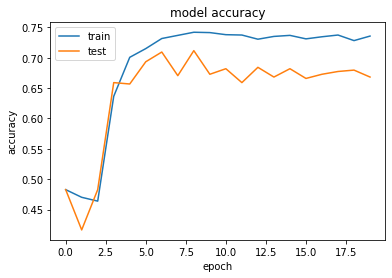

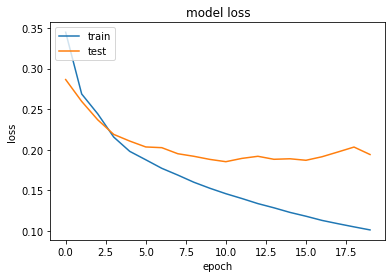

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# ALBERT

In [ ]:
config = AutoConfig.from_pretrained("m3hrdadfi/albert-fa-base-v2")
tokenizer = AutoTokenizer.from_pretrained("m3hrdadfi/albert-fa-base-v2")
bert_model = AutoModel.from_pretrained("m3hrdadfi/albert-fa-base-v2")

In [ ]:
# def get_embedding(sent):
#     input_sentence = torch.tensor(tokenizer.encode(sent, max_length = 500)).unsqueeze(0)
#     out = bert_model(input_sentence)
#     embeddings_of_last_layer = out[0]
#     cls_embeddings = embeddings_of_last_layer[0][0]
#     cls_embeddings = cls_embeddings.detach().numpy()
#     return cls_embeddings

In [ ]:
# df_types_bert = pd.read_csv("/content/drive/My Drive/topics-for-types/df_types.csv")

In [ ]:
# df_types_bert['sentence'] = df_types_bert['sentence'].apply(lambda sent: get_embedding(sent))
# df_types_bert.to_csv("/content/drive/My Drive/topics-for-types/df_types_bert.csv", index=False)
# df_types_bert.head()

,sentence,انتخاب,بله/خیر,ترجمه,تعامل,تعریف,توضیح,دلیل,ریاضی,لیست,نظر,واقعیت,پیشنهاد
0,"[-0.5841074, -0.017078003, -0.32405344, -0.645...",0,0,0,0,1,1,0,0,0,1,0,0
1,"[-0.31120673, -0.0050979797, 0.10509731, -0.36...",0,1,0,0,0,1,0,0,0,1,0,0
2,"[0.05544515, -0.23301096, 0.12021764, -0.33959...",0,0,0,0,0,1,1,0,0,1,0,0
3,"[0.37881416, -0.1909234, 0.16427912, -0.383240...",0,0,0,0,0,1,1,0,0,1,0,0
4,"[-0.46968994, -0.2401005, 0.20189604, -0.20498...",0,0,0,0,1,0,0,0,1,1,0,0


In [ ]:
df_types_bert = pd.read_csv("/content/drive/My Drive/topics-for-types/df_types_albert.csv")
df_types_bert['sentence'] = df_types_bert['sentence'].apply(lambda x: 
                           np.fromstring(
                               x.replace('\n','')
                                .replace('[','')
                                .replace(']','')
                                .replace('  ',' '), sep=' '))
df_types_bert.head()

,sentence,انتخاب,بله/خیر,ترجمه,تعامل,تعریف,توضیح,دلیل,ریاضی,لیست,نظر,واقعیت,پیشنهاد
0,"[-0.584107399, -0.0170780029, -0.324053437, -0...",0,0,0,0,1,1,0,0,0,1,0,0
1,"[-0.311206728, -0.00509797968, 0.105097309, -0...",0,1,0,0,0,1,0,0,0,1,0,0
2,"[0.0554451495, -0.233010963, 0.120217644, -0.3...",0,0,0,0,0,1,1,0,0,1,0,0
3,"[0.378814161, -0.190923393, 0.164279118, -0.38...",0,0,0,0,0,1,1,0,0,1,0,0
4,"[-0.469689935, -0.240100503, 0.201896042, -0.2...",0,0,0,0,1,0,0,0,1,1,0,0


In [ ]:
X = np.array(df_types_bert[df_types_bert.columns[0]])
X = np.vstack(X)

Y = df_types_bert[df_types_bert.columns[1:]].values

X.shape, Y.shape

((2424, 768), (2424, 12))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.10)

In [ ]:
len(X_train),len(X_test),len(y_train),len(y_test)

(2181, 243, 2181, 243)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=X[0].shape, name='input_layer'),
    tf.keras.layers.Dense(128, activation='relu', name='Dense_Layer',
                          activity_regularizer=tf.keras.regularizers.l2()),
    # tf.keras.layers.Dropout(rate=0.2, name="Dropout"),
    # tf.keras.layers.Dense(100, activation='relu', name='Dense_Layer2',
                          # activity_regularizer=tf.keras.regularizers.l2()),
    # tf.keras.layers.Dropout(rate=0.2, name="Dropout2"),
    tf.keras.layers.Dense(12, activation='sigmoid', name='Dense_Layer3'),

  ], name='ALBERT_MODEL')

model.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics=['acc',
                       tfa.metrics.f_scores.F1Score(12,'weighted', threshold=0.5, name='f1'),
                       tfa.metrics.f_scores.F1Score(12,'macro',threshold=0.5, name='macro'),
                       tfa.metrics.f_scores.F1Score(12,'micro',threshold=0.5, name='micro'),
                       tfa.metrics.HammingLoss(mode='multilabel',threshold=0.5, name='hamloss')])
print(model.summary())

Model: "BERT_MODEL"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_Layer (Dense)          (None, 128)               98432     
_________________________________________________________________
Dense_Layer3 (Dense)         (None, 12)                1548      
Total params: 99,980
Trainable params: 99,980
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history = model.fit(X_train, y_train, batch_size=8, epochs=20, verbose=1, validation_split=0.2)

Epoch 1/20
218/218 [==============================] - 1s 5ms/step - loss: 0.4548 - acc: 0.4765 - f1: 0.4969 - macro: 0.1542 - micro: 0.5778 - hamloss: 0.1141 - val_loss: 0.3659 - val_acc: 0.5011 - val_f1: 0.5506 - val_macro: 0.1732 - val_micro: 0.6462 - val_hamloss: 0.0990
Epoch 2/20
218/218 [==============================] - 1s 4ms/step - loss: 0.3315 - acc: 0.6009 - f1: 0.5848 - macro: 0.1861 - micro: 0.6789 - hamloss: 0.0901 - val_loss: 0.3187 - val_acc: 0.6087 - val_f1: 0.5523 - val_macro: 0.1742 - val_micro: 0.6498 - val_hamloss: 0.0974
Epoch 3/20
218/218 [==============================] - 1s 4ms/step - loss: 0.2953 - acc: 0.6640 - f1: 0.6051 - macro: 0.1948 - micro: 0.7001 - hamloss: 0.0860 - val_loss: 0.2914 - val_acc: 0.6934 - val_f1: 0.5965 - val_macro: 0.1957 - val_micro: 0.6871 - val_hamloss: 0.0915
Epoch 4/20
218/218 [==============================] - 1s 4ms/step - loss: 0.2715 - acc: 0.7064 - f1: 0.6204 - macro: 0.2043 - micro: 0.7117 - hamloss: 0.0824 - val_loss: 0.2753 -

In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)

8/8 [==============================] - 0s 3ms/step - loss: 0.2373 - acc: 0.6543 - f1: 0.7090 - macro: 0.3414 - micro: 0.7333 - hamloss: 0.0823


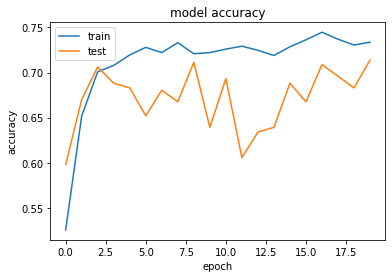

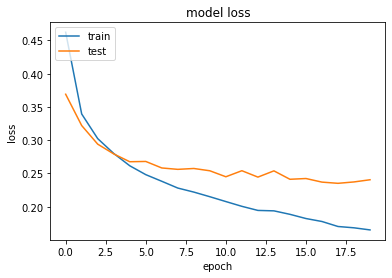

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# BERT

In [ ]:
bert_tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")  
bert_model = AutoModel.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")

In [ ]:
# def get_embedding(sent):
#     input_sentence = torch.tensor(bert_tokenizer.encode(sent, max_length = 500)).unsqueeze(0)
#     out = bert_model(input_sentence)
#     embeddings_of_last_layer = out[0]
#     cls_embeddings = embeddings_of_last_layer[0][0]
#     cls_embeddings = cls_embeddings.detach().numpy()
#     return cls_embeddings

In [ ]:
# df_types_bert = pd.read_csv("/content/drive/My Drive/topics-for-types/df_types.csv")

In [ ]:
# df_types_bert['sentence'] = df_types_bert['sentence'].apply(lambda sent: get_embedding(sent))
# df_types_bert.to_csv("/content/drive/My Drive/topics-for-types/df_types_bert.csv", index=False)
# df_types_bert.head()

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


,sentence,انتخاب,بله/خیر,ترجمه,تعامل,تعریف,توضیح,دلیل,ریاضی,لیست,نظر,واقعیت,پیشنهاد
0,"[-0.9806155, -0.25270098, -0.73519176, 0.52485...",0,0,0,0,1,1,0,0,0,1,0,0
1,"[-1.2237562, -1.0405048, -0.82329005, -0.51480...",0,1,0,0,0,1,0,0,0,1,0,0
2,"[-0.17114322, -0.8240524, -0.23230526, -0.3026...",0,0,0,0,0,1,1,0,0,1,0,0
3,"[-0.033276368, -0.39518848, -0.75779915, -0.28...",0,0,0,0,0,1,1,0,0,1,0,0
4,"[-1.226232, -0.88978004, -1.1824298, -0.173771...",0,0,0,0,1,0,0,0,1,1,0,0


In [ ]:
df_types_bert = pd.read_csv("/content/drive/My Drive/topics-for-types/df_types_albert.csv")
df_types_bert['sentence'] = df_types_bert['sentence'].apply(lambda x: 
                           np.fromstring(
                               x.replace('\n','')
                                .replace('[','')
                                .replace(']','')
                                .replace('  ',' '), sep=' '))
df_types_bert.head()

,sentence,انتخاب,بله/خیر,ترجمه,تعامل,تعریف,توضیح,دلیل,ریاضی,لیست,نظر,واقعیت,پیشنهاد
0,"[-0.584107399, -0.0170780029, -0.324053437, -0...",0,0,0,0,1,1,0,0,0,1,0,0
1,"[-0.311206728, -0.00509797968, 0.105097309, -0...",0,1,0,0,0,1,0,0,0,1,0,0
2,"[0.0554451495, -0.233010963, 0.120217644, -0.3...",0,0,0,0,0,1,1,0,0,1,0,0
3,"[0.378814161, -0.190923393, 0.164279118, -0.38...",0,0,0,0,0,1,1,0,0,1,0,0
4,"[-0.469689935, -0.240100503, 0.201896042, -0.2...",0,0,0,0,1,0,0,0,1,1,0,0


In [ ]:
X = np.array(df_types_bert[df_types_bert.columns[0]])
X = np.vstack(X)

Y = df_types_bert[df_types_bert.columns[1:]].values

X.shape, Y.shape

((2424, 768), (2424, 12))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.10)

In [ ]:
len(X_train),len(X_test),len(y_train),len(y_test)

(2181, 243, 2181, 243)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=X[0].shape, name='input_layer'),
    tf.keras.layers.Dense(128, activation='relu', name='Dense_Layer',
                          activity_regularizer=tf.keras.regularizers.l2()),
    # tf.keras.layers.Dropout(rate=0.2, name="Dropout"),
    # tf.keras.layers.Dense(100, activation='relu', name='Dense_Layer2',
                          # activity_regularizer=tf.keras.regularizers.l2()),
    # tf.keras.layers.Dropout(rate=0.2, name="Dropout2"),
    tf.keras.layers.Dense(12, activation='sigmoid', name='Dense_Layer3'),

  ], name='BERT_MODEL')

model.compile(loss='binary_crossentropy', optimizer='rmsprop', 
              metrics=['acc',
                       tfa.metrics.f_scores.F1Score(12,'weighted', threshold=0.5, name='f1'),
                       tfa.metrics.f_scores.F1Score(12,'macro',threshold=0.5, name='macro'),
                       tfa.metrics.f_scores.F1Score(12,'micro',threshold=0.5, name='micro'),
                       tfa.metrics.HammingLoss(mode='multilabel',threshold=0.5, name='hamloss')])
print(model.summary())

Model: "BERT_MODEL"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_Layer (Dense)          (None, 128)               98432     
_________________________________________________________________
Dense_Layer3 (Dense)         (None, 12)                1548      
Total params: 99,980
Trainable params: 99,980
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history = model.fit(X_train, y_train, batch_size=8, epochs=15, verbose=1, validation_split=0.2)

Epoch 1/15
218/218 [==============================] - 1s 5ms/step - loss: 0.4390 - acc: 0.4983 - f1: 0.5302 - macro: 0.1626 - micro: 0.6229 - hamloss: 0.1062 - val_loss: 0.3416 - val_acc: 0.6659 - val_f1: 0.5627 - val_macro: 0.1710 - val_micro: 0.6736 - val_hamloss: 0.0892
Epoch 2/15
218/218 [==============================] - 1s 4ms/step - loss: 0.3207 - acc: 0.6302 - f1: 0.5945 - macro: 0.1922 - micro: 0.6852 - hamloss: 0.0909 - val_loss: 0.3014 - val_acc: 0.7162 - val_f1: 0.5804 - val_macro: 0.1795 - val_micro: 0.6851 - val_hamloss: 0.0868
Epoch 3/15
218/218 [==============================] - 1s 4ms/step - loss: 0.2823 - acc: 0.6669 - f1: 0.6154 - macro: 0.2033 - micro: 0.7031 - hamloss: 0.0862 - val_loss: 0.2676 - val_acc: 0.7048 - val_f1: 0.6239 - val_macro: 0.2070 - val_micro: 0.7125 - val_hamloss: 0.0814
Epoch 4/15
218/218 [==============================] - 1s 4ms/step - loss: 0.2602 - acc: 0.6909 - f1: 0.6326 - macro: 0.2163 - micro: 0.7141 - hamloss: 0.0831 - val_loss: 0.2598 -

In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)

8/8 [==============================] - 0s 4ms/step - loss: 0.2340 - acc: 0.6996 - f1: 0.7040 - macro: 0.3521 - micro: 0.7432 - hamloss: 0.0782


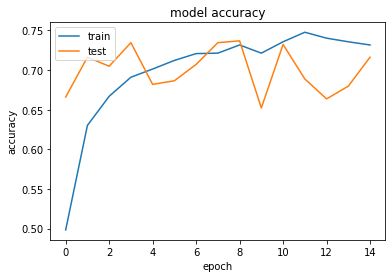

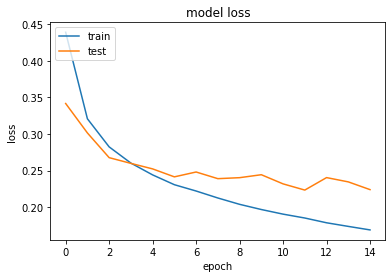

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# Word2Vec

In [6]:
embeddings_dictionary = dict()

w2v_file = open('drive/My Drive/nlp/similarity/embeddings/twitt_wiki_ham_blog.fa.text.100.vec', encoding="utf8")

for line in w2v_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
w2v_file.close()

In [7]:
df_types_w2v = pd.read_csv("/content/drive/My Drive/topics-for-types/df_types.csv")
df_types_w2v.head()

,sentence,انتخاب,بله/خیر,ترجمه,تعامل,تعریف,توضیح,دلیل,ریاضی,لیست,نظر,واقعیت,پیشنهاد
0,تفاوت ترمز عقب دیسکی و کاسه ای چیست؟,0,0,0,0,1,1,0,0,0,1,0,0
1,آیا ترمز ضدقفل ABS در همه چرخ ها عمل می کند؟,0,1,0,0,0,1,0,0,0,1,0,0
2,چرا باوجود نصب بودن ترمز ABS بر روی خودرو، ترم...,0,0,0,0,0,1,1,0,0,1,0,0
3,چرا با وجود نصب بودن Airbag بر روی خودرو، در ه...,0,0,0,0,0,1,1,0,0,1,0,0
4,کلاس های مختلف خودرو چگونه شناسایی می شوند؟,0,0,0,0,1,0,0,0,1,1,0,0


In [8]:
parsivar_tokenizer = Tokenizer()
parsivar_normalizer = Normalizer(statistical_space_correction=False)

In [9]:
def get_w2v_embedding(sent):
    sent_tokens = parsivar_tokenizer.tokenize_words(parsivar_normalizer.normalize(sent))
    tokens_embeddings = []
    for token in sent_tokens:
      if token in embeddings_dictionary.keys():
        tokens_embeddings.append(embeddings_dictionary[token])
    sent_embedding = np.mean(tokens_embeddings, axis=0)
    return sent_embedding

In [10]:
df_types_w2v['sentence'] = df_types_w2v['sentence'].apply(lambda sent: get_w2v_embedding(sent))
df_types_w2v.head()

,sentence,انتخاب,بله/خیر,ترجمه,تعامل,تعریف,توضیح,دلیل,ریاضی,لیست,نظر,واقعیت,پیشنهاد
0,"[0.15668367, -0.28389242, 0.9089176, 0.5482701...",0,0,0,0,1,1,0,0,0,1,0,0
1,"[-0.1255625, -1.6543719, -0.7273559, 0.4527906...",0,1,0,0,0,1,0,0,0,1,0,0
2,"[-0.06706425, -1.0731599, 1.2626698, 0.399987,...",0,0,0,0,0,1,1,0,0,1,0,0
3,"[0.3817483, -1.376912, 0.92743206, 1.1186554, ...",0,0,0,0,0,1,1,0,0,1,0,0
4,"[0.9607437, -0.767353, -2.3159149, -0.20033674...",0,0,0,0,1,0,0,0,1,1,0,0


In [11]:
X = np.array(df_types_w2v[df_types_w2v.columns[0]])
X = np.vstack(X)

Y = df_types_w2v[df_types_w2v.columns[1:]].values
n_class = Y.shape[1]

X.shape, Y.shape

((2424, 100), (2424, 12))

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.10)

In [13]:
len(X_train),len(X_test),len(y_train),len(y_test)

(2181, 243, 2181, 243)

In [20]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=X[0].shape, name='input_layer'),
    # tf.keras.layers.Dense(32, activation='relu', name='Dense_Layer0'),
    # tf.keras.layers.Dropout(rate=0.2, name="Dropout0"),
    tf.keras.layers.Dense(32, activation='relu', name='Dense_Layer1'),
                          # activity_regularizer=tf.keras.regularizers.l2()),
    
    # tf.keras.layers.Dropout(rate=0.2, name="Dropout1"),
    # tf.keras.layers.Dense(32, activation='relu', name='Dense_Layer2'),
                          # activity_regularizer=tf.keras.regularizers.l2()),
    # tf.keras.layers.Dropout(rate=0.2, name="Dropout2"),
    tf.keras.layers.Dense(n_class, activation='sigmoid', name='Dense_Layer3'),

  ], name='Word2Vec_MODEL')

model.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics=['acc',
                       tfa.metrics.f_scores.F1Score(n_class,'weighted', threshold=0.5, name='f1'),
                       tfa.metrics.f_scores.F1Score(n_class,'macro',threshold=0.5, name='macro'),
                       tfa.metrics.f_scores.F1Score(n_class,'micro',threshold=0.5, name='micro'),
                       tfa.metrics.HammingLoss(mode='multilabel',threshold=0.5, name='hamloss')])
print(model.summary())

Model: "Word2Vec_MODEL"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_Layer1 (Dense)         (None, 32)                3232      
_________________________________________________________________
Dense_Layer3 (Dense)         (None, 12)                396       
Total params: 3,628
Trainable params: 3,628
Non-trainable params: 0
_________________________________________________________________
None


In [21]:
history = model.fit(X_train, y_train, batch_size=8, epochs=20, verbose=1, validation_split=0.2)

Epoch 1/20
218/218 [==============================] - 1s 6ms/step - loss: 0.3741 - acc: 0.4272 - f1: 0.5153 - macro: 0.1992 - micro: 0.5046 - hamloss: 0.1701 - val_loss: 0.2720 - val_acc: 0.5034 - val_f1: 0.5615 - val_macro: 0.2081 - val_micro: 0.6249 - val_hamloss: 0.1085
Epoch 2/20
218/218 [==============================] - 1s 4ms/step - loss: 0.2522 - acc: 0.5378 - f1: 0.5919 - macro: 0.2525 - micro: 0.6465 - hamloss: 0.1035 - val_loss: 0.2509 - val_acc: 0.5515 - val_f1: 0.6003 - val_macro: 0.2486 - val_micro: 0.6526 - val_hamloss: 0.1034
Epoch 3/20
218/218 [==============================] - 1s 5ms/step - loss: 0.2329 - acc: 0.5602 - f1: 0.6249 - macro: 0.2842 - micro: 0.6723 - hamloss: 0.0967 - val_loss: 0.2420 - val_acc: 0.5721 - val_f1: 0.6346 - val_macro: 0.2823 - val_micro: 0.6709 - val_hamloss: 0.0997
Epoch 4/20
218/218 [==============================] - 1s 5ms/step - loss: 0.2206 - acc: 0.5872 - f1: 0.6547 - macro: 0.3117 - micro: 0.6960 - hamloss: 0.0908 - val_loss: 0.2350 -

In [22]:
score = model.evaluate(X_test, y_test, verbose=1)

8/8 [==============================] - 0s 3ms/step - loss: 0.2278 - acc: 0.6049 - f1: 0.6961 - macro: 0.4719 - micro: 0.7106 - hamloss: 0.0888


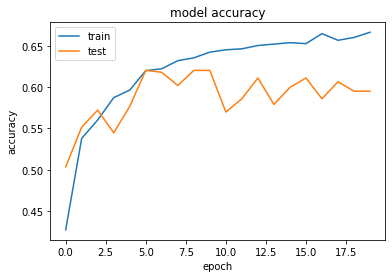

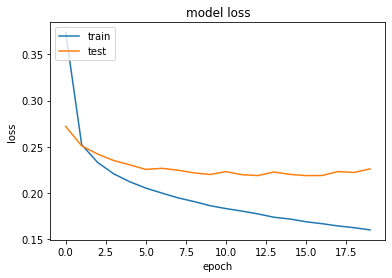

In [23]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()